# Study - E vs Delta-Z

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Nov 26 11:50:01 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   scipy import optimize
import invisible_cities.core.fit_functions as fitf
from  invisible_cities.core .core_functions import in_range

import krcal.utils.plt_functions          as krplot
import krcal.utils.hst_extend_functions   as hst

import csth.utils.cepeak_plot             as cpkplot

In [4]:
# Plotting style
default_cmap = "jet"
figure_size  = 14, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [11]:
run_numbers = [6482, 6483, 6484, 6485]
trigger    = 'trigger2'
#input_filename = f"$IC_DATA/{run_number}/pmaps/cepks_{run_number}_90_9188_{trigger}.h5"
tag = '6q0min'
input_filenames = [f"$IC_DATA/{run_number}/cepks/cepks_{run_number}_0000_11999_{tag}.h5" for run_number in run_numbers]
input_files     = [os.path.expandvars(ifile) for ifile in input_filenames]

In [12]:
def esum_from_hdf(filename, clear = True):
    print(filename)
    h = pd.HDFStore(filename)
    esum = h['esum']
    print('total events :', len(esum))
    esum.dropna()
    sel_base = (esum.nslices > 0) & (esum.nhits > 0) & (esum.zmax < 650.) & (esum.s1e >0)
    esum = esum[sel_base]
    print('clean events :', len(esum) )
    #esum0 = esum[sel_base]
    #h.close()
    return esum

In [13]:
esums = [esum_from_hdf(ifile) for ifile in input_files]

/Users/hernando/investigacion/NEXT/data/runIV//6482/cepks/cepks_6482_0000_11999_6q0min.h5
total events : 556662
clean events : 546432
/Users/hernando/investigacion/NEXT/data/runIV//6483/cepks/cepks_6483_0000_11999_6q0min.h5
total events : 522662
clean events : 513328
/Users/hernando/investigacion/NEXT/data/runIV//6484/cepks/cepks_6484_0000_11999_6q0min.h5
total events : 528351
clean events : 518915
/Users/hernando/investigacion/NEXT/data/runIV//6485/cepks/cepks_6485_0000_11999_6q0min.h5
total events : 444251
clean events : 436515


In [14]:
#cpkplot.df(esum)

In [21]:
Ea = hst.Vaxis((0., 800e3), 500)
def canvas_e(esums):
    alpha = 1./len(esums)
    #c = hst.Canvas(1, 1)
    for i, esum in enumerate(esums):
        plt.hist(esum.e, Ea.bins, alpha = alpha) 
        plt.xlabel('E (pes)')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()

No handles with labels found to put in legend.


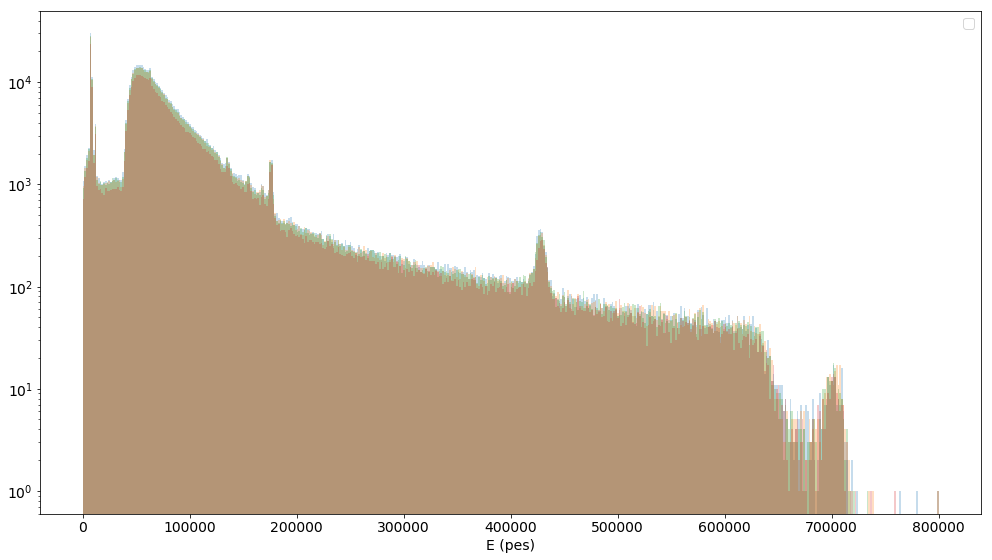

In [22]:
canvas_e(esums)

In [29]:
tags = [str(run) for run in run_numbers]
Exra = hst.Vaxis((  5e3,  10e3), 100)
Ecsa = hst.Vaxis((110e3, 190e3), 100)
Edsa = hst.Vaxis((350e3, 450e3), 100)
Etha = hst.Vaxis((500e3, 800e3), 100)
def canvas_eregions(esums, i0 = 0):
    alpha = 1./len(esums)
    c = hst.Canvas(2, 2)
    for i, esum in enumerate(esums):
        hst.hist(esum.e, Exra.bins, alpha = alpha, stats = None, canvas = c(1), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Ecsa.bins, alpha = alpha, stats = None, canvas = c(2), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Edsa.bins, alpha = alpha, stats = None, canvas = c(3), label = tags[i + i0], xylabels=('E (pes)',''))
        hst.hist(esum.e, Etha.bins, alpha = alpha, stats = None, canvas = c(4), label = tags[i + i0], xylabels=('E (pes)',''))
    plt.legend()
    plt.tight_layout()

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


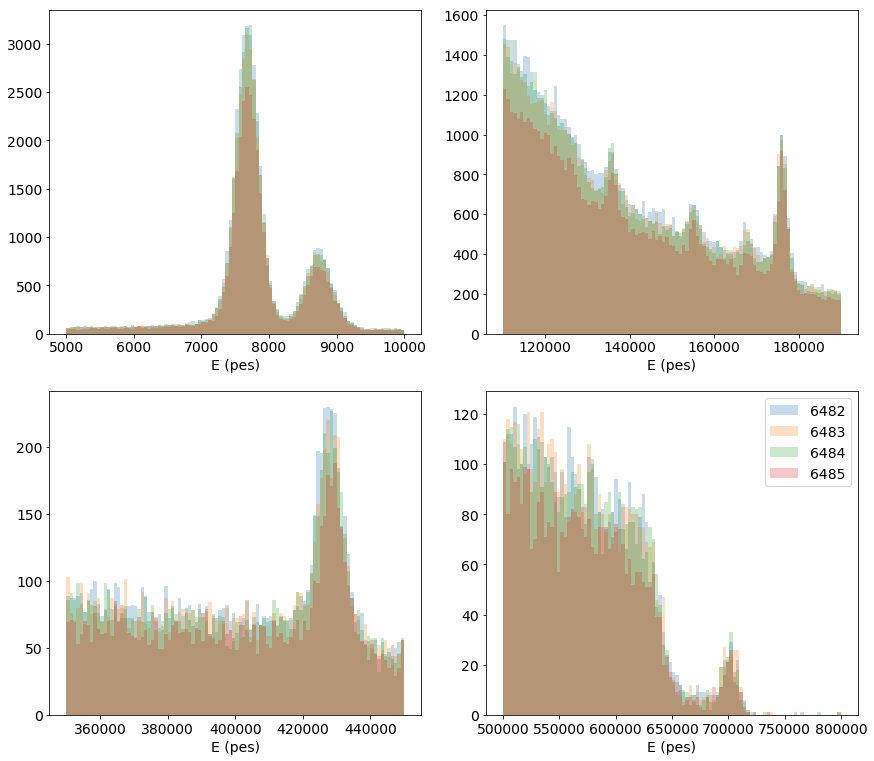

In [30]:
canvas_eregions(esums, 0)
#canvas_eregions(esums[4:],  4)

In [52]:
import csth.utils.fits as efit

def plot_extll_fit(es, e0, e1, mushat, nbins = 100, alpha = 0.5, tag = ''):
    pg = efit.Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')
    mu, sigma, mslope, nug, nup = mushat[0], mushat[1], mushat[2], mushat[3], mushat[4]
    ntot = nug + nup
    f = float(nug)/float(nug+nup)
    pf = efit.Pol1DGaus(a = e0, b = e1, shapes = 'mu, sigma, mslope, f')
    xs = np.linspace(e0, e1, nbins)
    dx = xs[1]-xs[0]
    ys = ntot * dx * pg.pdf(xs, mu = mu, sigma = sigma, mslope = mslope, f = f)
    plt.hist(es, nbins, range = (e0, e1), alpha = alpha)
    fwhm = 235.* sigma/mu
    label = tag + ' n = ' + str(int(nug)) + ', $\mu$ = ' + "{0:.0f}".format(mu) + ', FWHM (%) = ' + "{0:.2f}".format(fwhm)
    plt.plot(xs, ys, ls= '-', lw = 2, label = label, alpha = alpha)
    plt.xlim(e0, e1)
    plt.legend(fontsize=11)
    return (xs, ys)
    

In [32]:
def canvas_esigma(esum, erange, nbins= 100, tag='', alpha = 0.5):
    e0, e1 = erange
    dssel = in_range(esum.e, e0, e1)
    es = esum.e[dssel]
    mushat = efit.extll_fit_pol1dgaus(es, e0, e1)
    print(es.min(), es.max())
    #plt.hist(es, nbins, range = (360e3, 440e3))
    #plt.xlim(e0, e1)
    dat = plot_extll_fit(es, e0, e1, mushat, tag = tag, alpha = alpha)
    return mushat, dat

400006.2723231764 449974.5105902258
400028.3461778632 449995.77356633043
400003.62017967144 449950.16326885234
400006.5965501759 449980.1595986889


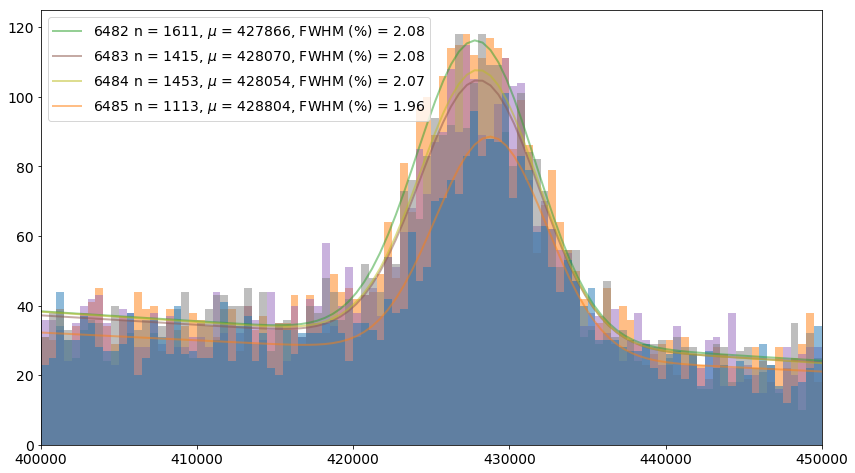

In [35]:
i0 = 0
for i, esum in enumerate(esums):
    tag = tags[i0 + i]
    canvas_esigma(esum, (400e3, 450e3), tag = tag, alpha = 0.5);
    

170000.23902046715 184986.2345084028
170000.10409415807 184994.87733120646
170002.57420290157 184997.40594753055
170002.97276569682 184989.79960849945


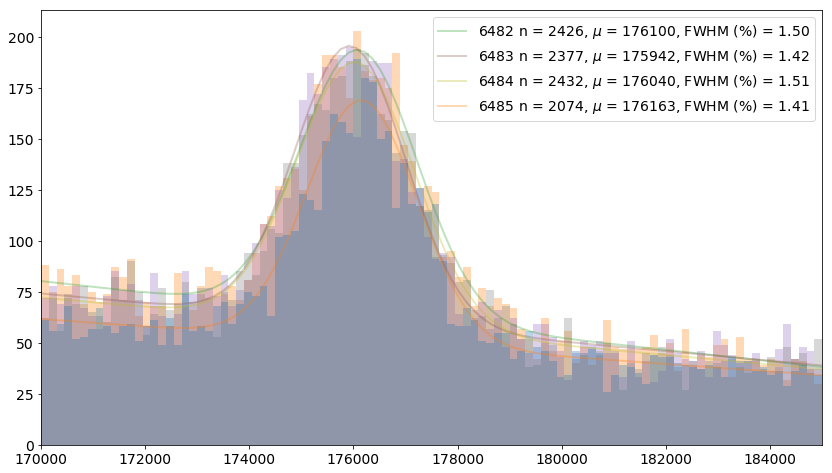

In [36]:
i0 = 0
for i, esum in enumerate(esums):
    tag = tags[i0 + i]
    canvas_esigma(esum, (170e3, 185e3), tag = tag, alpha = 0.3);
    

7000.1214374257415 8198.47383626201
7000.0170275140445 8199.741691993555
7001.173562065434 8199.642217620789
7000.3139468894105 8199.78027495312


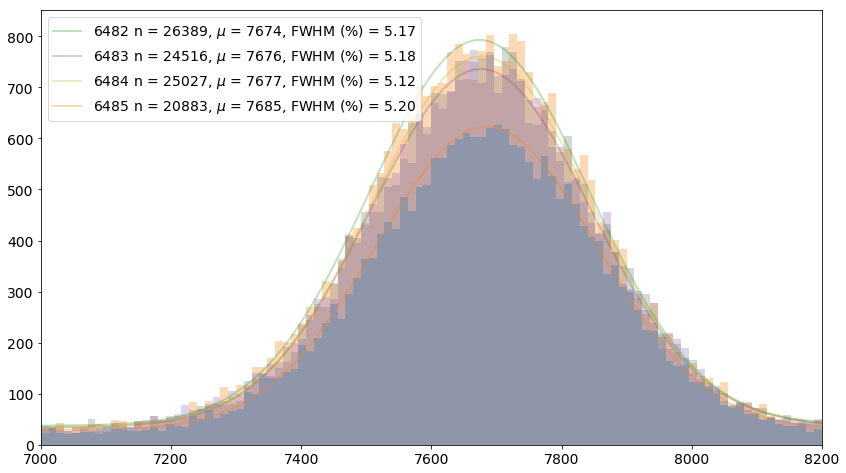

In [38]:
i0 = 0
for i, esum in enumerate(esums):
    tag = tags[i0 + i]
    canvas_esigma(esum, (7.0e3, 8.2e3), tag = tag, alpha = 0.3);

In [39]:
i0 = 4
for i, esum in enumerate(esums[4:]):
    tag = tags[i0 + i]
    canvas_esigma(esum, (6.5e3, 7.8e3), tag = tag, alpha = 0.3);

670350.2484263262 718755.8850185286
670564.2473704788 718686.5095972932
670041.118996889 717471.5669575606
670803.7146552117 717855.5666310649


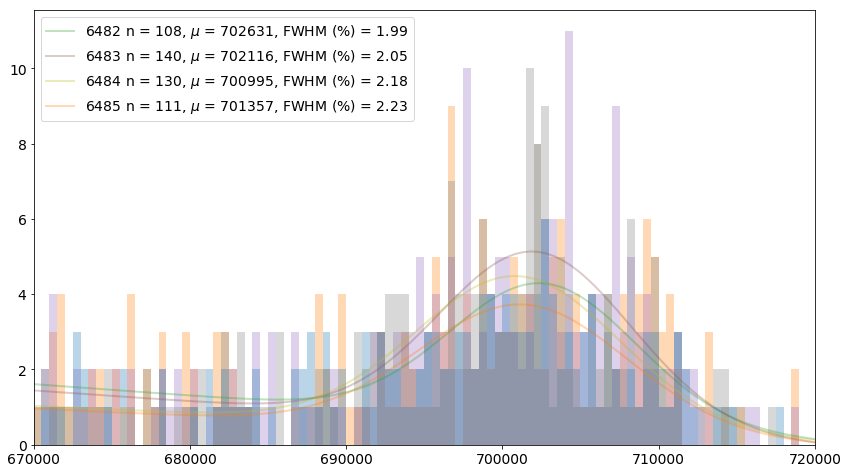

In [42]:
i0 = 0
for i, esum in enumerate(esums):
    tag = tags[i0 + i]
    canvas_esigma(esum, (670e3, 720e3), tag = tag, alpha = 0.3);

In [49]:
esum = esums[0]
print(len(esum))
for i, iesum in enumerate(esums[1:]):
    esum = esum.append(iesum, ignore_index = True)
print(len(esum))

546432
2015190


/Users/hernando/investigacion/NEXT/work/ICAROS/csth/utils/fits.py:42: RuntimeWarning: divide by zero encountered in log
  llog1 = -2.*np.sum(np.log(stats.poisson.pmf(n, mu = nug + nup)))


7000.0170275140445 8199.78027495312
170000.10409415807 184997.40594753055
410005.45050729066 449995.77356633043
670041.118996889 718755.8850185286


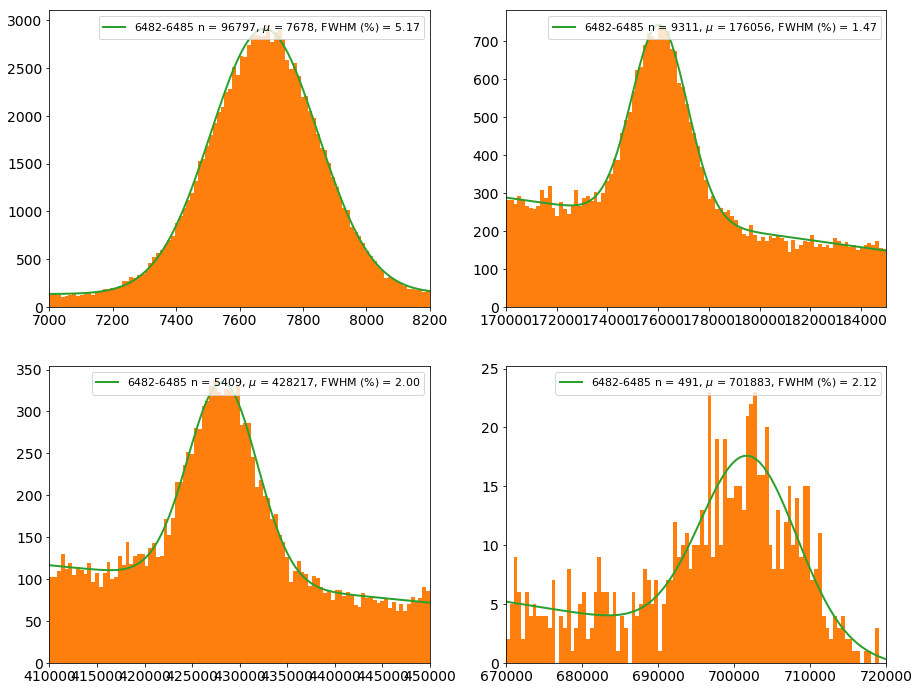

In [54]:
tag = '6482-6485'
fig = plt.figure(figsize= (15, 12))
plt.subplot(2, 2, 1)
canvas_esigma(esum, (7.0e3, 8.2e3), tag = tag, alpha = 1.);
plt.subplot(2, 2, 2)
canvas_esigma(esum, (170e3, 185e3), tag = tag, alpha = 1.);
plt.subplot(2, 2, 3)
canvas_esigma(esum, (410e3, 450e3), tag = tag, alpha = 1.);
plt.subplot(2, 2, 4)
canvas_esigma(esum, (670e3, 720e3), tag = tag, alpha = 1.);

## Studying DS

In [58]:
esum.eqh = esum.eh/esum.qh
esum.eq  = esum.e/esum.q

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [101]:
def canvas_eq_vs_var(esum, varname, varax, eax, alpha = 0.05):
    var = esum[varname].values
    xsel = (in_range(esum.e, *eax.range)) & (in_range(var, *varax.range))
    c = hst.Canvas(3, 2)
    c(1)
    plt.scatter(var [xsel], esum.e [xsel], alpha = alpha)
    plt.grid()
    c(2)
    plt.hist2d (var [xsel], esum.e [xsel], (50, 50))
    plt.grid()
    xs, ys, eys = fitf.profileX(var[xsel], esum.e[xsel], 50)
    hst.errorbar(xs, ys, yerr=eys, fmt='*', canvas=c(2), c='black')    
    c(3)
    plt.scatter(var [xsel], esum.q [xsel], alpha = alpha)
    plt.grid()
    c(4)
    plt.hist2d (var [xsel], esum.q [xsel], (50, 50))
    xs, ys, eys = fitf.profileX(var[xsel], esum.q[xsel], 50)
    hst.errorbar(xs, ys, yerr=eys, fmt='*', canvas=c(4), c='black')  
    plt.grid()
    c(5)
    plt.scatter(var [xsel], esum.eq[xsel], alpha = alpha)
    plt.grid()
    c(6)
    plt.hist2d (var [xsel], esum.eq[xsel], (50, 50))
    xs, ys, eys = fitf.profileX(var[xsel], esum.eq[xsel], 50)
    hst.errorbar(xs, ys, yerr=eys, fmt='*', canvas=c(6), c='black')  
    plt.grid()
    return
    

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


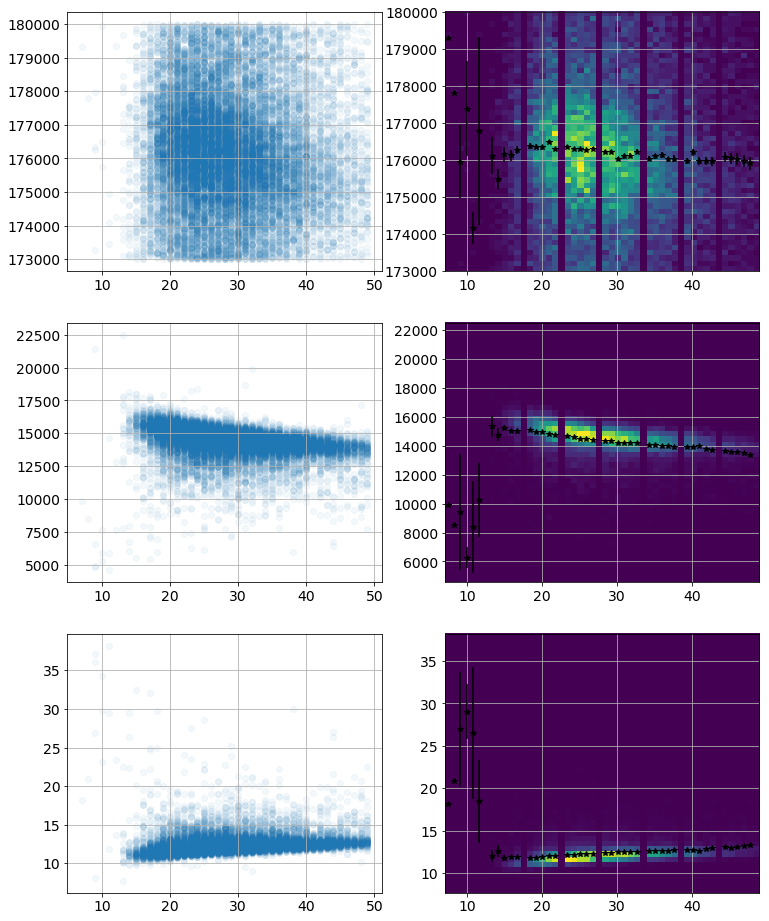

In [106]:
eax  = hst.Vaxis((173e3, 180e3), 50)
vax  = hst.Vaxis((0    , 50)  , 50)
canvas_eq_vs_var(esum, 'nslices', vax, eax)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


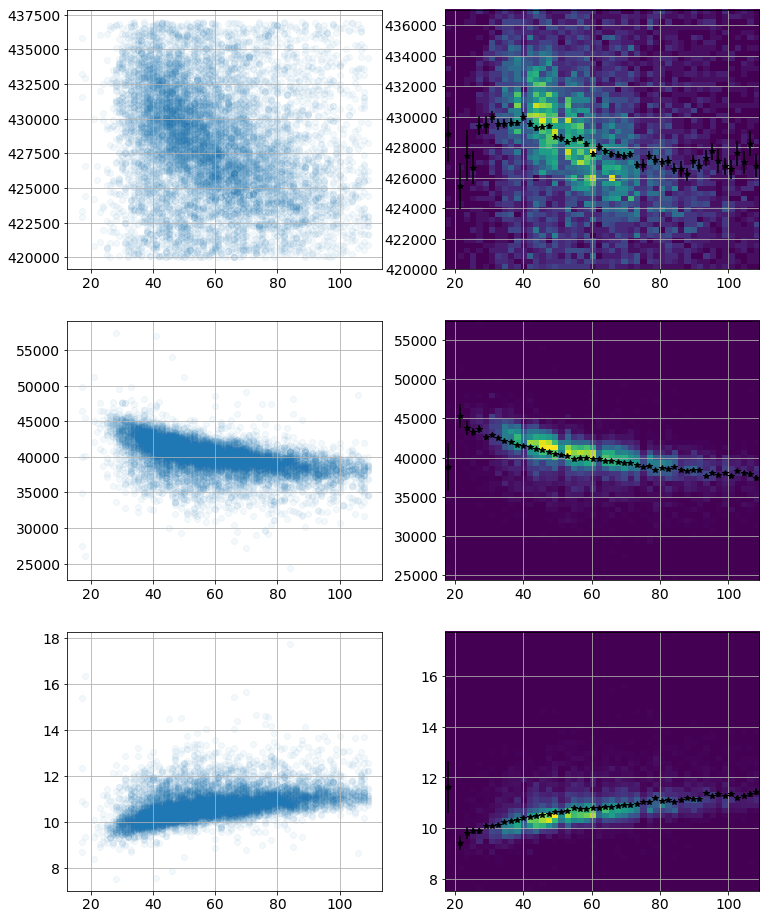

In [132]:
eax  = hst.Vaxis((420e3, 437e3), 50)
vax  = hst.Vaxis((0    , 110)  , 50)
canvas_eq_vs_var(esum, 'nslices', vax, eax)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


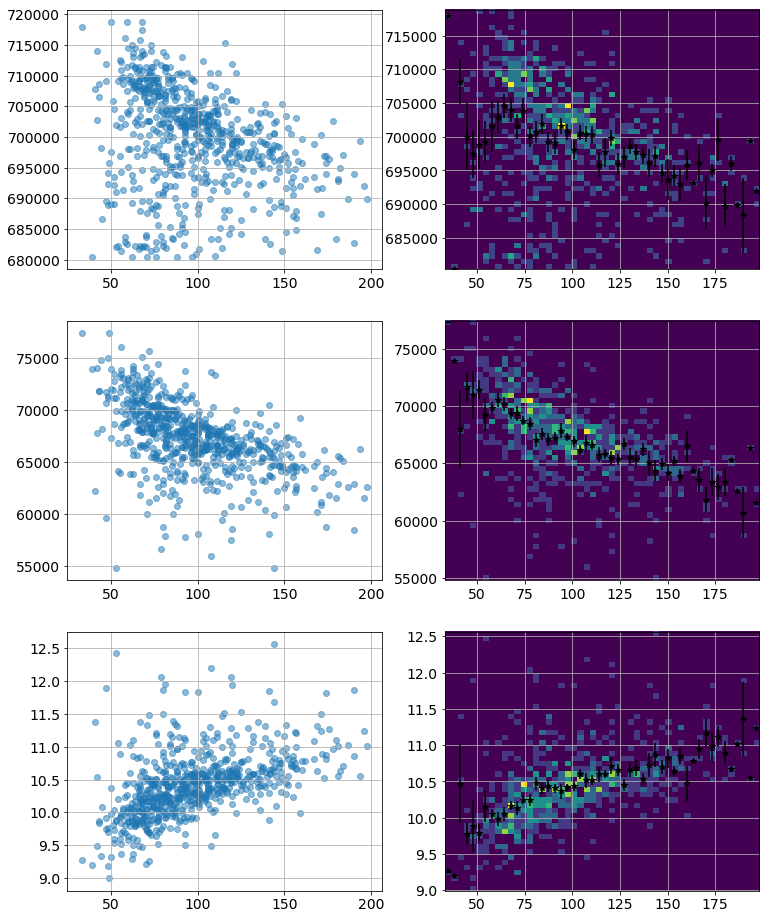

In [110]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((0    , 200)  , 50)
canvas_eq_vs_var(esum, 'nslices', vax, eax, alpha = 0.5)

In [114]:
esum.columns

Index(['event', 'peak', 'location', 'nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x0', 'y0', 'z0', 'e0',
       'q0', 'e0h', 'q0h', 'x', 'y', 'z', 'q', 'e', 'eh', 'qh', 'xu', 'yu',
       'zu', 'e0f', 'e0b', 'ef', 'eb', 'e1', 'x1', 'y1', 'z1', 'e2', 'x2',
       'y2', 'z2', 'eblob1', 'eblob2', 'd12'],
      dtype='object')

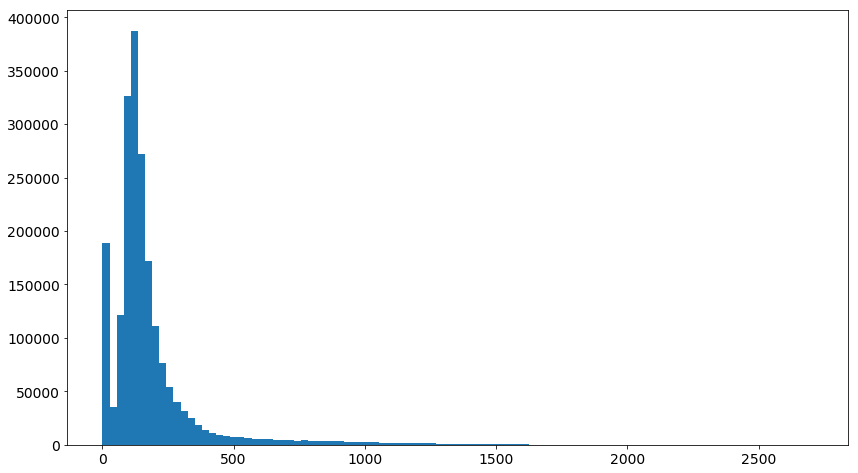

In [117]:
plt.hist(esum.nhits, 100);

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


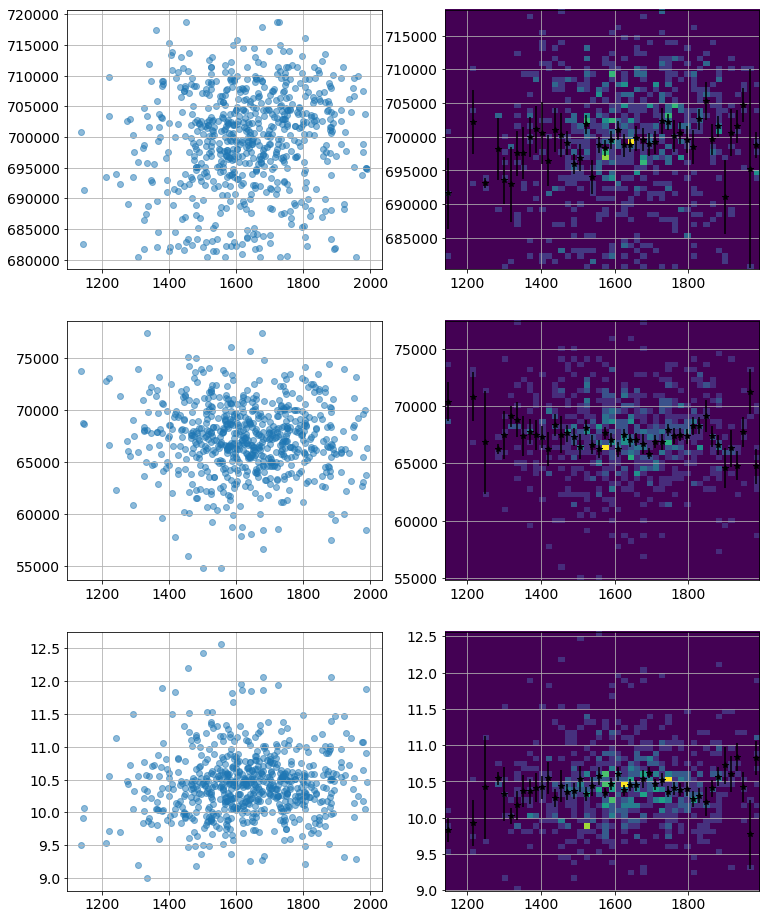

In [120]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((0    , 2000)  ,50)
canvas_eq_vs_var(esum, 'nhits', vax, eax, alpha = 0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


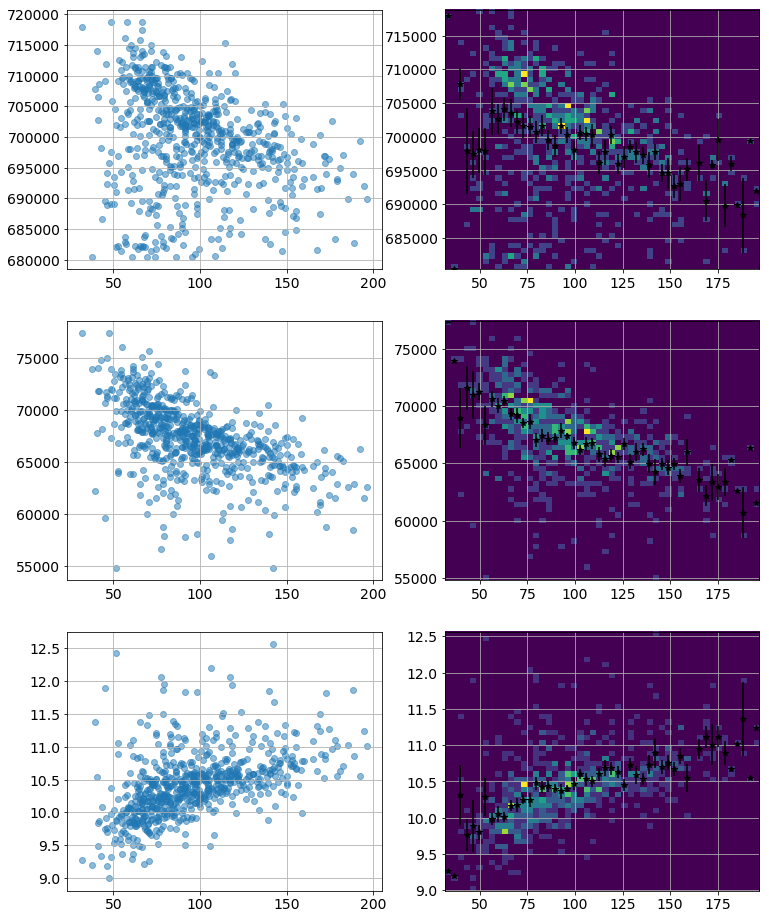

In [121]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((0    , 200)  ,50)
canvas_eq_vs_var(esum, 'zsize', vax, eax, alpha = 0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


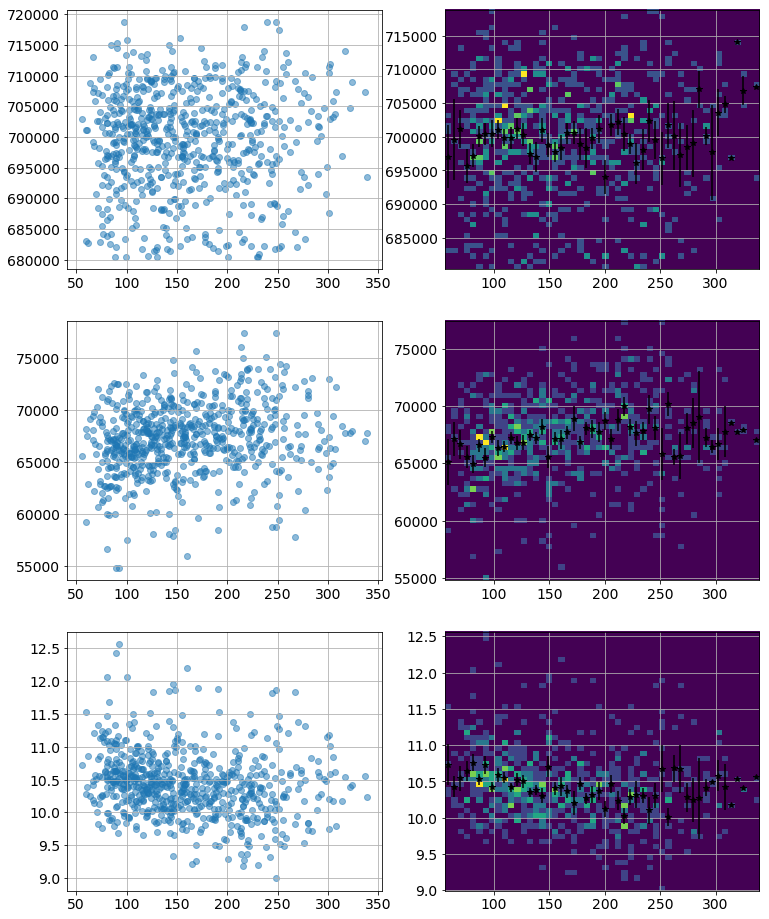

In [123]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((0    , 350)  ,50)
canvas_eq_vs_var(esum, 'rsize', vax, eax, alpha = 0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


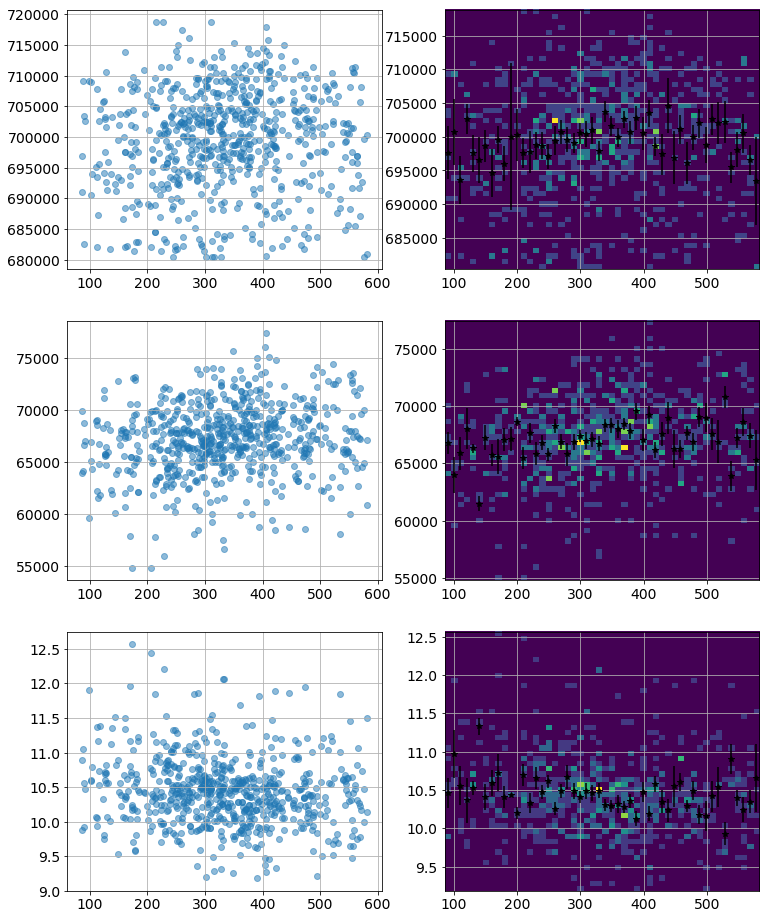

In [124]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((0    , 600)  ,50)
canvas_eq_vs_var(esum, 'zmax', vax, eax, alpha = 0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


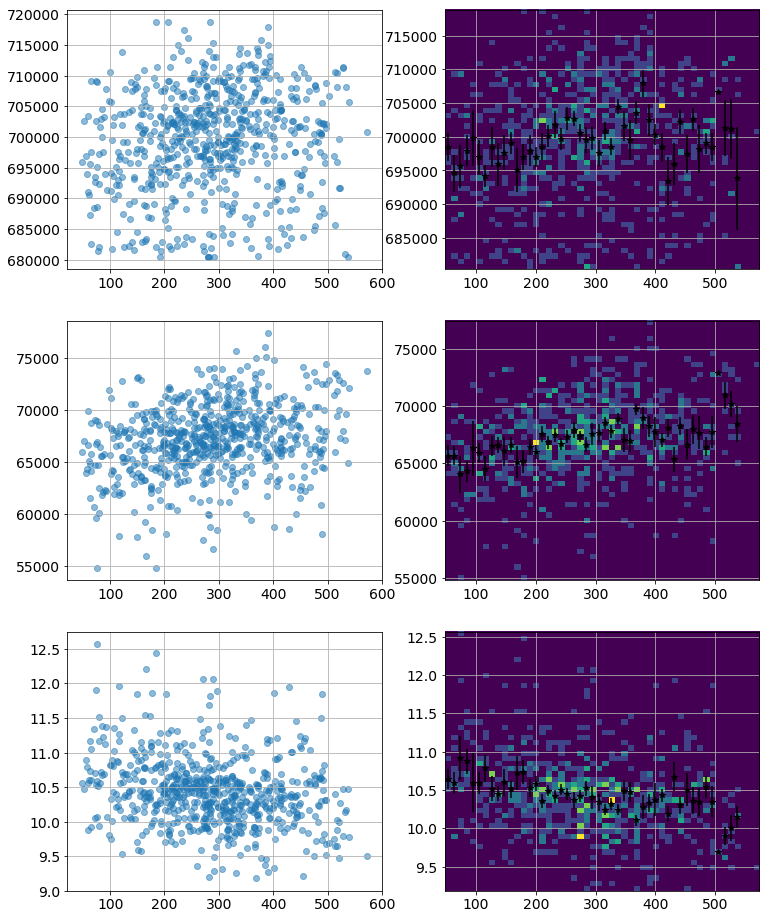

In [125]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((0    , 600)  ,50)
canvas_eq_vs_var(esum, 'z', vax, eax, alpha = 0.5)

/Users/hernando/investigacion/NEXT/work/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/hernando/investigacion/NEXT/work/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


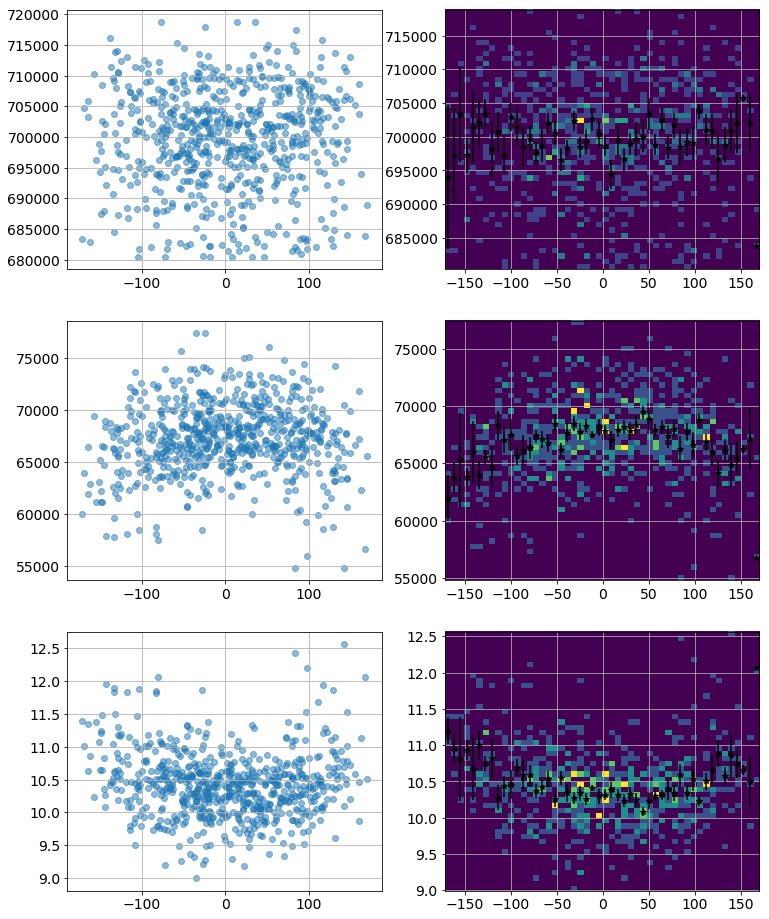

In [126]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((-250 , 250)  , 50)
canvas_eq_vs_var(esum, 'x', vax, eax, alpha = 0.5)

/Users/hernando/investigacion/NEXT/work/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in greater_equal
  return (minval <= data) & (data < maxval)
/Users/hernando/investigacion/NEXT/work/IC/invisible_cities/core/core_functions.py:81: RuntimeWarning: invalid value encountered in less
  return (minval <= data) & (data < maxval)
/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


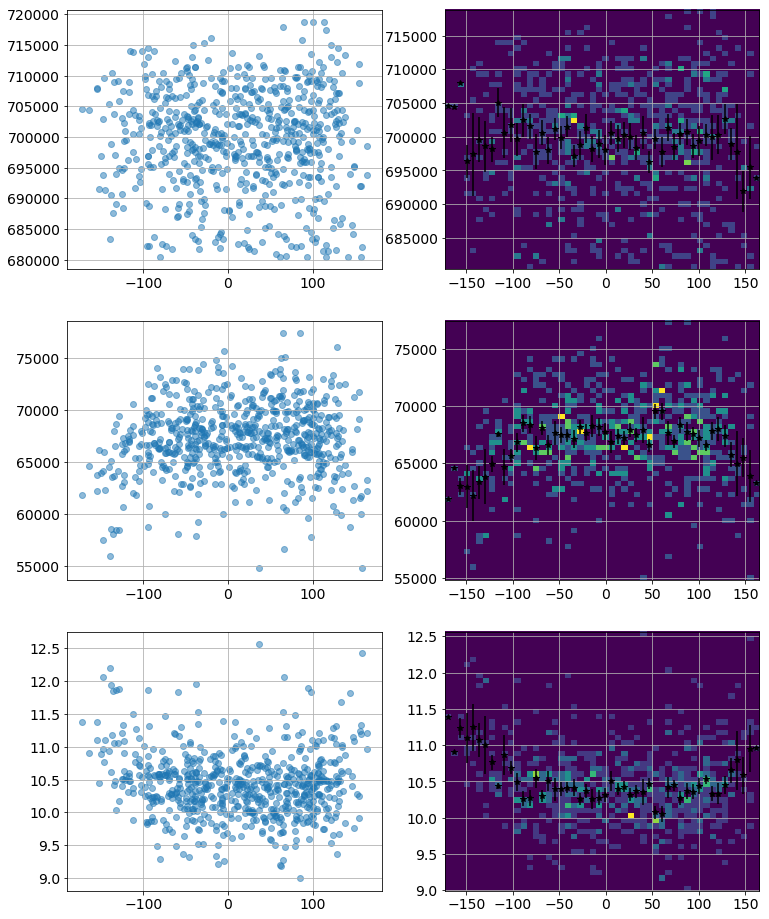

In [127]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((-250 , 250)  , 50)
canvas_eq_vs_var(esum, 'y', vax, eax, alpha = 0.5)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


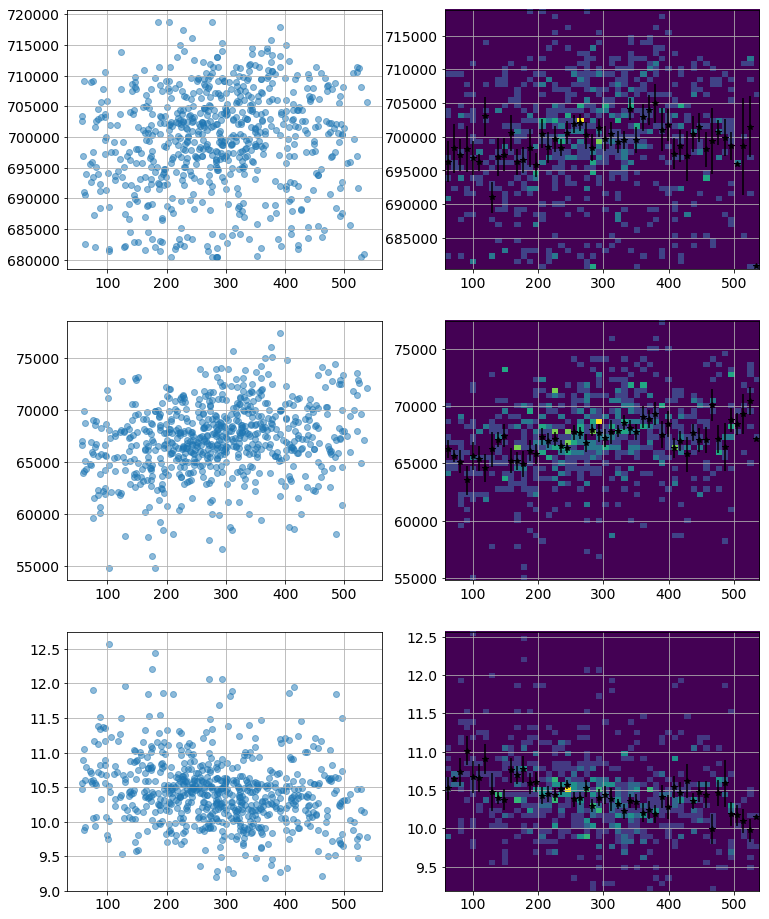

In [129]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((0 , 550)  , 50)
canvas_eq_vs_var(esum, 'zu', vax, eax, alpha = 0.5)

In [ ]:
eax  = hst.Vaxis((680e3, 720e3), 50)
vax  = hst.Vaxis((-250 , 250)  , 50)
canvas_eq_vs_var(esum, 'x', vax, eax, alpha = 0.5)

In [185]:
xrsel = in_range(esum.e,  72e3,  82e3)
cssel = in_range(esum.e, 122e3, 180e3)
sbsel = in_range(esum.e, 403e3, 420e3)
dssel = in_range(esum.e, 420e3, 437e3)
tlsel = in_range(esum.e, 680e3, 720e3)

In [186]:
esum['abf'] = (esum.eb - esum.ef)/(esum.eb + esum.ef)
esum['dz1'] =  (esum.z1 - esum.zu) #/esum.zsize

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


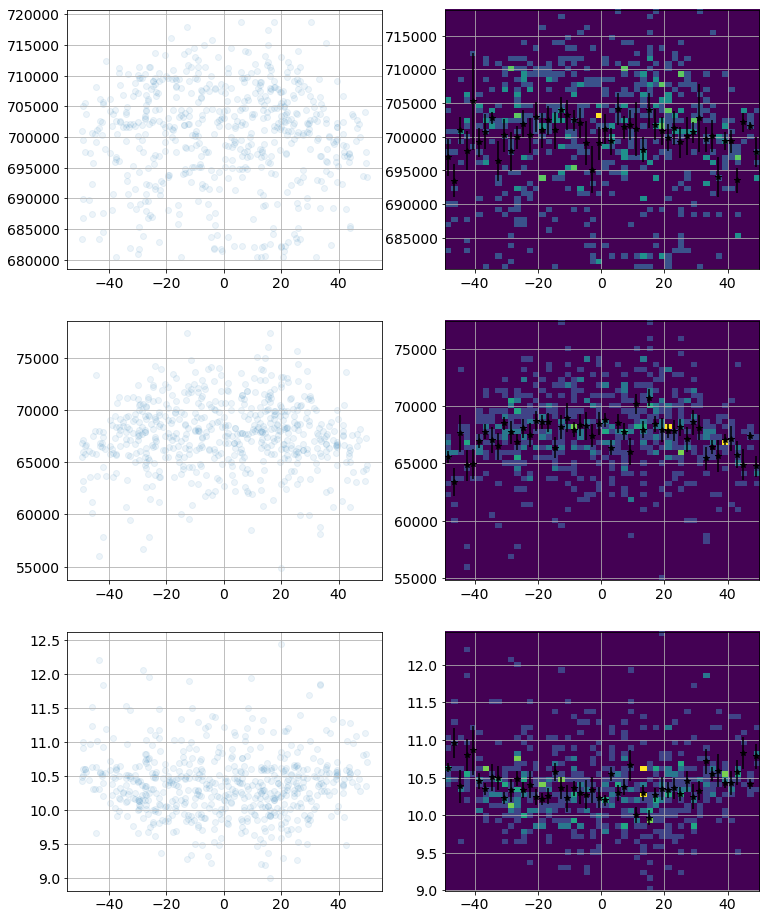

In [181]:
eax  = hst.Vaxis((680e3, 720e3), 50)
#eax  = hst.Vaxis((420e3, 437e3), 40)
vax  = hst.Vaxis((-50 , 50.)  , 40)
canvas_eq_vs_var(esum, 'dz1', vax, eax, alpha = 0.08)

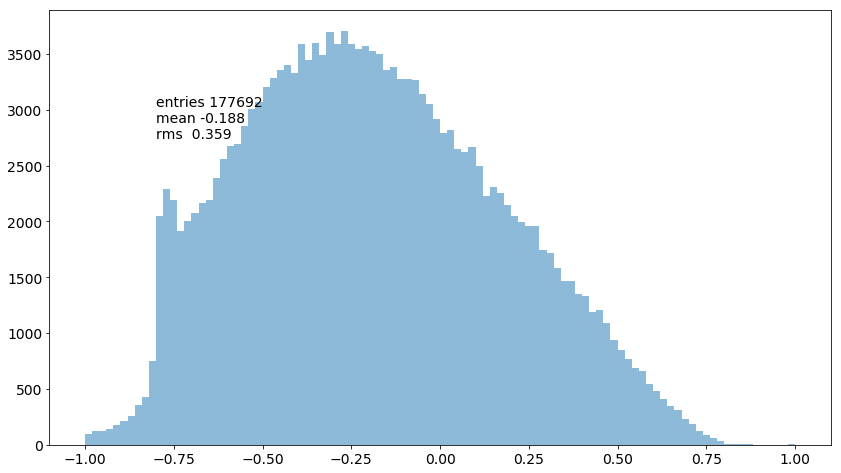

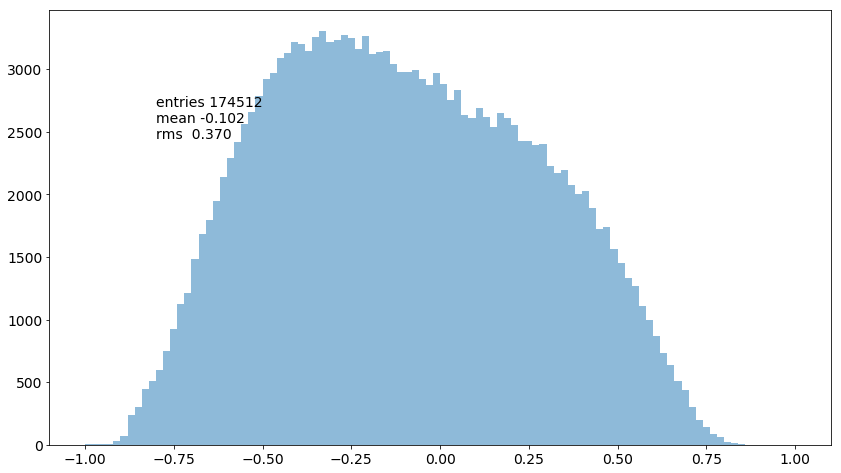

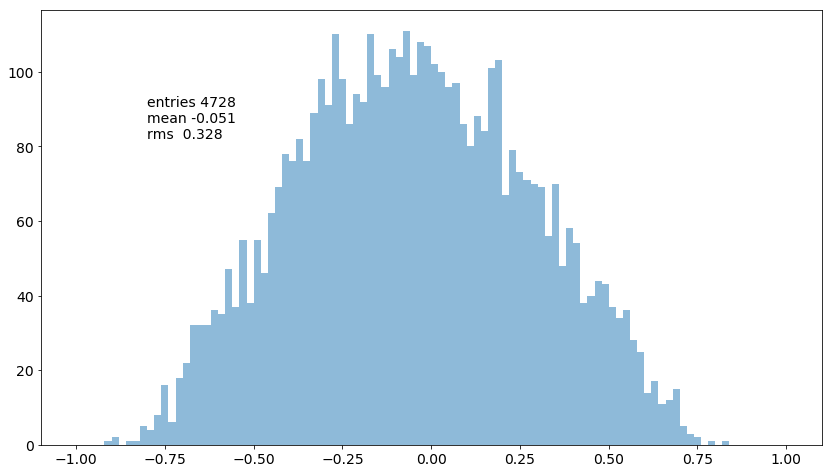

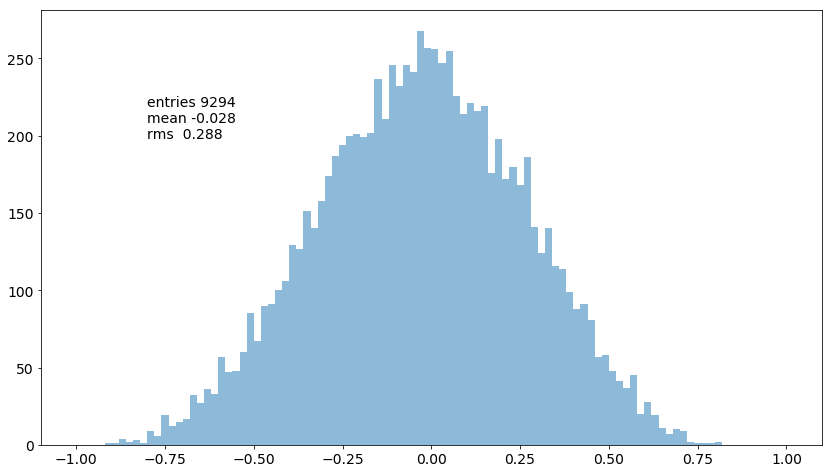

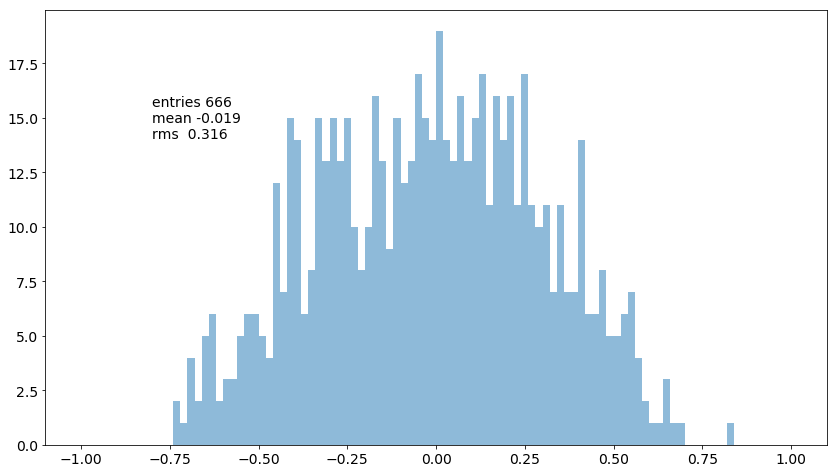

In [187]:
hst.hist(esum.abf[xrsel], 100, (-1., 1.), alpha = 0.5);
hst.hist(esum.abf[cssel], 100, (-1., 1.), alpha = 0.5);
hst.hist(esum.abf[sbsel], 100, (-1., 1.), alpha = 0.5);
hst.hist(esum.abf[dssel], 100, (-1., 1.), alpha = 0.5);
hst.hist(esum.abf[tlsel], 100, (-1., 1.), alpha = 0.5);
#plt.yscale('log');

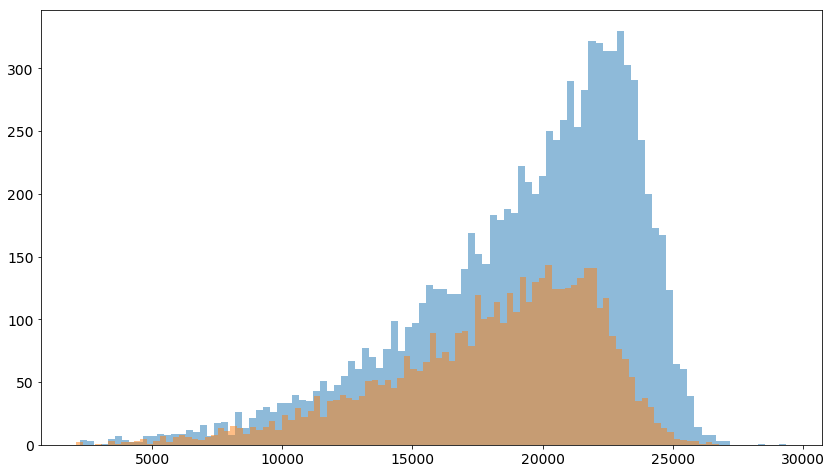

In [247]:
esum['ablob'] = abs(esum.eblob1 - esum.eblob2)
esum['cblob'] =    (esum.eblob1 + esum.eblob2)
esum['dz12']  = abs(esum.z1 - esum.z2)
plt.hist(esum.cblob[dssel], 100, alpha = 0.5);
plt.hist(esum.cblob[sbsel], 100, alpha = 0.5);
#plt.scatter(esum.e[sbsel], esum.ablob[sbsel], alpha = 0.2);
#plt.scatter(esum.e[dssel], esum.ablob[dssel], alpha = 0.2);
#plt.hist(esum.eblob1[dssel], 100, alpha = 0.5);

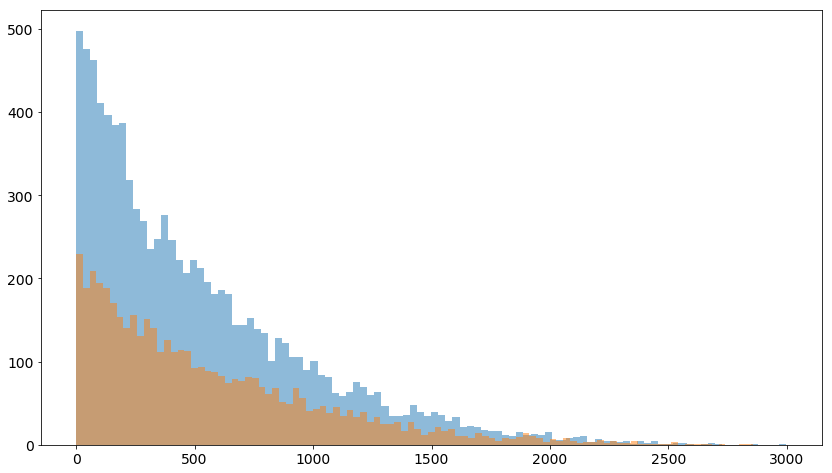

In [249]:
esum['ae12'] = abs(esum.e1 - esum.e2)
esum['ce12'] =    (esum.e1 + esum.e2)
plt.hist(esum.ae12[dssel], 100, alpha = 0.5);
plt.hist(esum.ae12[sbsel], 100, alpha = 0.5);
#plt.scatter(esum.e[sbsel], esum.ablob[sbsel], alpha = 0.2);
#plt.scatter(esum.e[dssel], esum.ablob[dssel], alpha = 0.2);
#plt.hist(esum.eblob1[dssel], 100, alpha = 0.5);

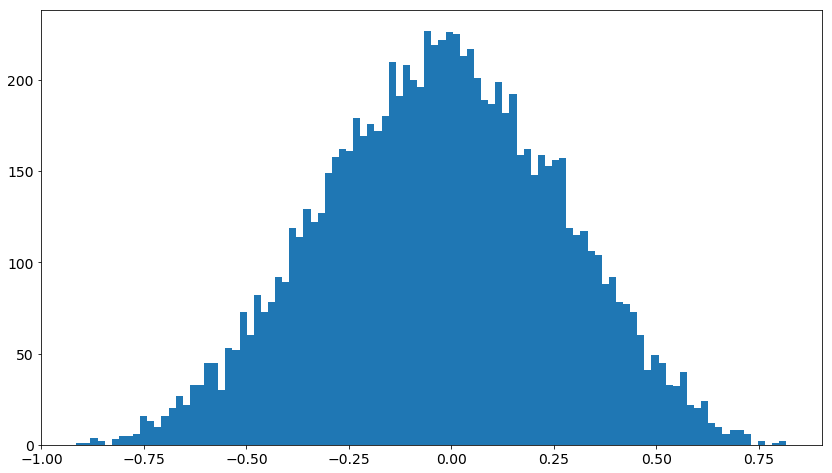

In [256]:
plt.hist(esum.abf[dssel], 100);

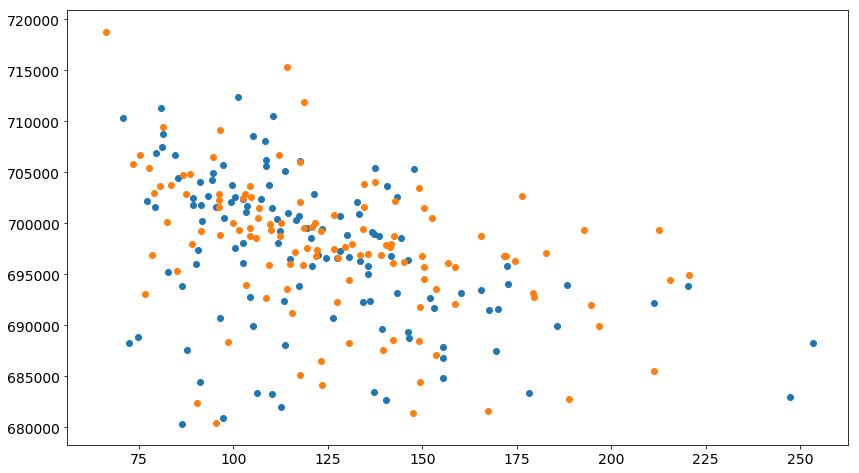

In [484]:
esel = in_range(esum.e, 680e3, 720e3)
#xsel = esel & ((esum.z - esum.zu) < 0.) & (esum.zsize > 80.) # (in_range(esum.zsize, 00., 50))
xsel = esel & (esum.z1 - esum.zu < -30.) & (esum.zsize > 0.) # (in_range(esum.zsize, 00., 50))

plt.scatter(esum.zsize[xsel], esum.e[xsel], alpha = 1.)
#plt.scatter(esum.dz1[xsel]/esum.zsize[xsel], esum.dz2[xsel]/esum.zsize[xsel], alpha = 0.5);

#hst.hist(esum.dz1[xsel]/esum.zsize[xsel] - esum.dz2[xsel]/esum.zsize[xsel], 100, alpha = 0.5);
#xsel = esel & ((esum.z - esum.zu) > 0.) & (esum.zsize > 80.) # (in_range(esum.zsize, 50., 110))
xsel = esel & (esum.z1 - esum.zu > 30.) & (esum.zsize > 0.) # (in_range(esum.zsize, 50., 110))

plt.scatter(esum.zsize[xsel], esum.e[xsel], alpha = 1.)


#plt.hist(esum.e[xsel], 25, normed = 1., alpha = 0.5);
#plt.scatter(esum.dz1[xsel]/esum.zsize[xsel], esum.dz2[xsel]/esum.zsize[xsel], alpha = 0.5);
#hst.hist(esum.dz1[xsel]/esum.zsize[xsel] - esum.dz2[xsel]/esum.zsize[xsel], 100, alpha = 0.5);




#hst.hist(esum.dz1[xsel], 100, alpha = 0.5)
#plt.scatter(esum.dz1[xsel], esum.dz2[xsel], alpha = 0.1)
#plt.hist(esum.e[xsel], 100, alpha = 0.5)
#xsel = dssel & (in_range(esum.zsize, 00., 150))
#plt.scatter(esum.dz1[xsel]/esum.zsize[xsel], esum.dz2[xsel]/esum.zsize[xsel], alpha = 0.5);
#hst.hist(esum.dz1[xsel], 100, alpha = 0.5);
#plt.hist(esum.abf[xsel], 100, alpha = 0.5);
#plt.scatter(abs(esum.zsize[xsel]), esum.e[xsel], alpha = 0.5);
#plt.hist(esum.e[xsel], 100, alpha = 0.5);


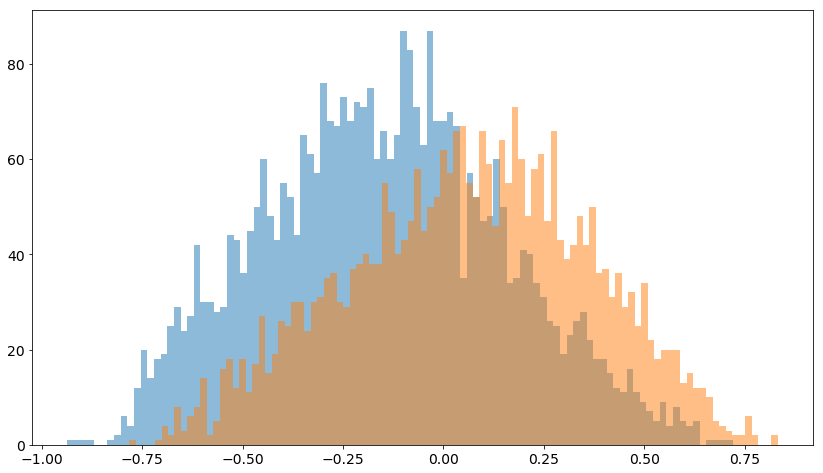

In [423]:
esel = in_range(esum.e, 410e3, 450e3)
dz = 0.
xsel = esel & (esum.dz1 < -dz) & (esum.dz2 < -dz) & (esum.zsize > 50)
plt.hist(esum.abf[xsel], 100, alpha = 0.5);
esel = in_range(esum.e, 410e3, 450e3)
xsel = esel & (esum.dz1 >  dz) & (esum.dz2 > dz) & (esum.zsize > 50)
plt.hist(esum.abf[xsel], 100, alpha = 0.5);




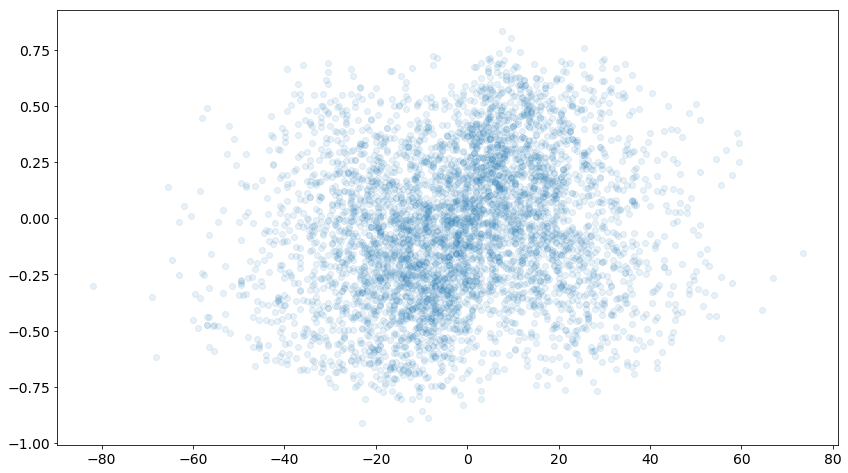

In [191]:
xsel = sbsel
plt.scatter(esum.dz1[xsel], esum.abf[xsel], alpha = 0.1)

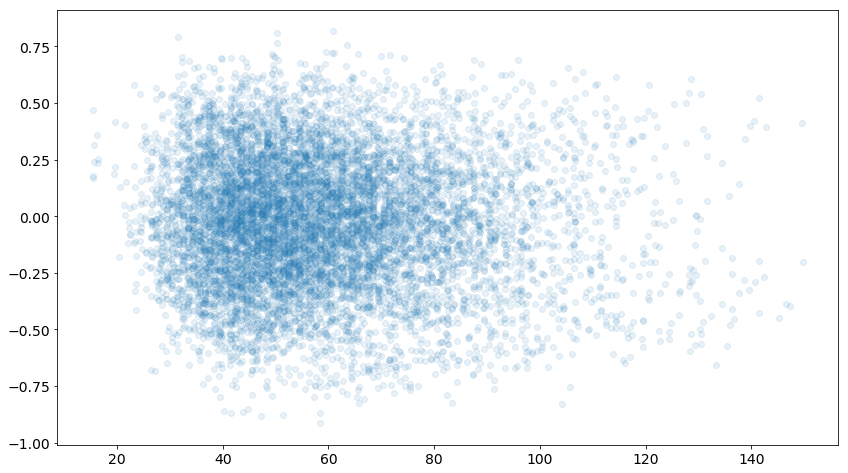

In [150]:
xsel = dssel & in_range(esum.zsize, 0, 150.)
plt.scatter(esum.zsize[xsel], esum.abf[xsel], alpha = 0.1);

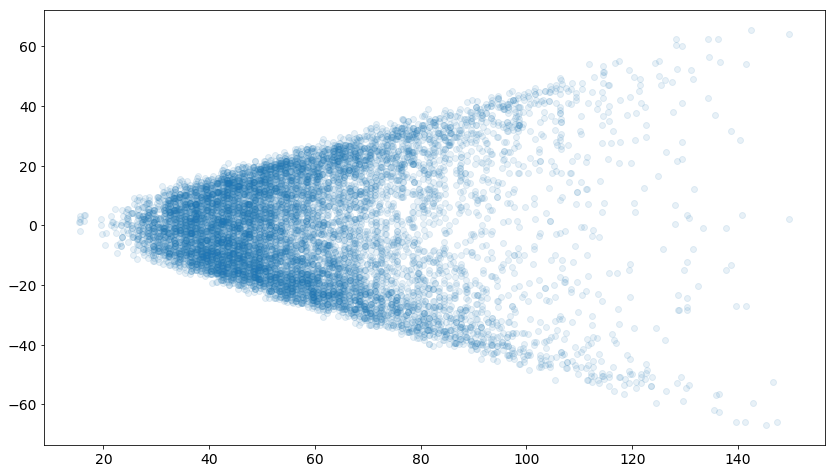

In [152]:
esum.dz1 = esum.z1 - esum.zu
esum.dz2 = esum.z2 - esum.zu
plt.scatter(esum.zsize[xsel], esum.dz1[xsel], alpha = 0.1);

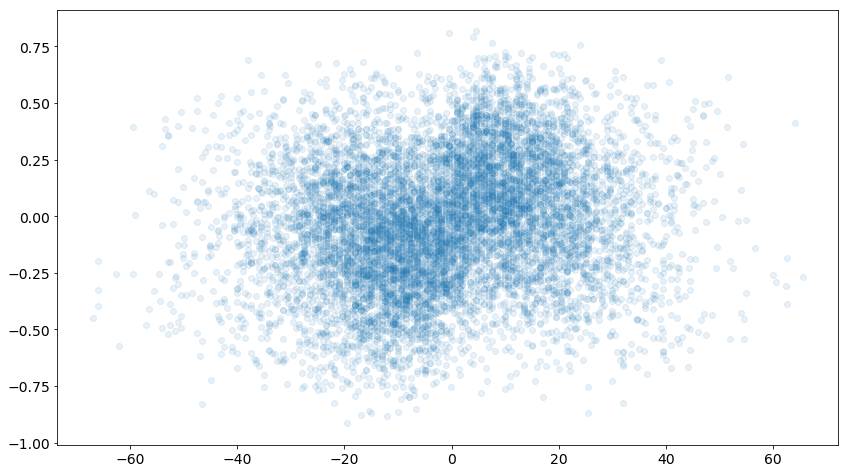

In [157]:
plt.scatter(esum.dz1[xsel], esum.abf[xsel], alpha = 0.1)

In [128]:
esum.columns

Index(['event', 'peak', 'location', 'nslices', 'nhits', 'noqslices', 'time',
       's1e', 't0', 'rmax', 'rsize', 'zmax', 'zsize', 'x0', 'y0', 'z0', 'e0',
       'q0', 'e0h', 'q0h', 'x', 'y', 'z', 'q', 'e', 'eh', 'qh', 'xu', 'yu',
       'zu', 'e0f', 'e0b', 'ef', 'eb', 'e1', 'x1', 'y1', 'z1', 'e2', 'x2',
       'y2', 'z2', 'eblob1', 'eblob2', 'd12'],
      dtype='object')

In [ ]:
canvas_eq_vs_var('nslices', (350e3, 450e3))

In [ ]:
Edsa = hst.Vaxis((350e3, 400e3), 50)
Edsb = hst.Vaxis((400e3, 420e3), 50)
xsela =  ((esum.e > 350e3) & (esum.e <400e3))
xselb = in_range(esum.e, 400e3, 420e3)
xselc = in_range(esum.e, 420e3, 470e3)
xsels = [xsela, xselb]

vars = ['e',  'q', 'e0', 'q0', 'nslices', 'nhits', 'noqslices', 'zsize', 'rsize', 'e1', 'e2', 'd12']

c = hst.Canvas(len(vars), 1)
for i, var in enumerate(vars):
    c(i+1)
    for xsel in xsels:
        x = esum[var]
        plt.hist(x.values[xsel], 100, alpha = 0.5)
    plt.xlabel(var)


In [ ]:
plt.hist(esum.eb/esum.e, 100, alpha = 0.5, label = 'back');
plt.hist(esum.ef/esum.e, 100, alpha = 0.5, label = 'for');
plt.legend();

In [ ]:
#xselds = in_range(esum.e, 380e3, 440e3)
esum.eq = esum.e/esum.q
eqa = hst.Vaxis((0.,    50), 100)
ea  = hst.Vaxis((0., 750e3), 500)
plt.scatter(esum.e, esum.eq, alpha = 0.01);
plt.ylim(0, 40)
plt.xlim(0., 750e3)
#plt.hist2d(esum.q[xselds], esum.zsize[xselds], (40, 40), alpha = 1);

In [ ]:
esum.eq   = esum.e/esum.q
esum.efe  = esum.ef/esum.e
esum.ebe  = esum.eb/esum.e
esum.efbe = (esum.ef-esum.eb)/esum.e

In [ ]:
selds = in_range(esum.e, 380e3, 440e3)
alpha = 0.08
c = hst.Canvas(8, 2)
c(1)
plt.scatter(esum.e[selds], esum.eq[selds], alpha = alpha)
c(2)
plt.scatter(esum.e[selds], esum.zsize[selds], alpha = alpha)
c(3)
plt.scatter(esum.e[selds], esum.rsize[selds], alpha = alpha)
c(4)
plt.scatter(esum.e[selds], esum.zmax[selds], alpha = alpha)
c(5)
plt.scatter(esum.e[selds], esum.rmax[selds], alpha = alpha)
c(6)
plt.scatter(esum.e[selds], esum.x[selds], alpha = alpha)
c(7)
plt.scatter(esum.e[selds], esum.y[selds], alpha = alpha)
c(8)
plt.scatter(esum.e[selds], esum.z[selds], alpha = alpha)
c(9)
plt.scatter(esum.e[selds], esum.xu[selds], alpha = alpha)
c(10)
plt.scatter(esum.e[selds], esum.yu[selds], alpha = alpha)
c(11)
plt.scatter(esum.e[selds], esum.zu[selds], alpha = alpha)
c(12)
plt.scatter(esum.e[selds], esum.nslices[selds], alpha = alpha)
c(13)
plt.scatter(esum.e[selds], esum.nhits[selds], alpha = alpha)
c(14)
plt.scatter(esum.e[selds], esum.ebe[selds], alpha = alpha)
c(15)
plt.scatter(esum.e[selds], esum.efe[selds], alpha = alpha)
c(16)
plt.scatter(esum.e[selds], esum.efbe[selds], alpha = alpha)

plt.tight_layout();

In [ ]:
c = hst.Canvas(2, 2)
c(1)
plt.scatter(esum.zsize[selds], esum.ebe[selds], alpha = alpha)
c(2)
plt.scatter(esum.zsize[selds], esum.efe[selds], alpha = alpha)
c(3)
plt.scatter(esum.zsize[selds], esum.efbe[selds], alpha = alpha)

In [ ]:
xsel = selds & (esum.zsize > 120)
hst.hist(esum.efbe[xsel], 100, alpha = 0.5);
#plt.hist(esum.ebe[xsel], 100, alpha = 0.5);

In [ ]:
hst.hprofile(esum.zsize[selds], esum.efbe[selds], (40, 40))

In [ ]:
plt.scatter(esum.zsize[selds], esum.z1[selds]-esum.zu[selds], alpha = alpha)

In [ ]:
xsel = selds & (esum.zsize > 100)
hst.hist(esum.z[xsel]-esum.zu[xsel], 100);

In [ ]:
plt.scatter(esum.zsize[xsela], esum.eb[xsela]/esum.e[xsela], alpha = 0.1);

In [ ]:
c = hst.Canvas(2, 2)
plt.hist(esum.nhits[xsela], 100, (0, 1000), alpha = 0.5)
plt.hist(esum.nhits[xselb], 100, (0, 100), alpha = 0.5)



In [ ]:
plt.hist(esum.d12[xsel], 200);